In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from PIL import Image
import random
from collections import defaultdict
import cv2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
import random
import time

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [28]:
train_dir = '/kaggle/input/dataset-aol-dl/Disaster Dataset'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

df.head()

filepaths      labels
0  /kaggle/input/dataset-aol-dl/Disaster Dataset/...  Urban_Fire
1  /kaggle/input/dataset-aol-dl/Disaster Dataset/...  Urban_Fire
2  /kaggle/input/dataset-aol-dl/Disaster Dataset/...  Urban_Fire
3  /kaggle/input/dataset-aol-dl/Disaster Dataset/...  Urban_Fire
4  /kaggle/input/dataset-aol-dl/Disaster Dataset/...  Urban_Fire

In [29]:
train_df, other_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = seed_value)
valid_df, test_df = train_test_split(other_df, train_size = 0.5, shuffle = True, random_state = seed_value)

In [30]:
class_counts = train_df['labels'].value_counts()
print(f"Original class distribution:\n{class_counts}")

balanced_train_df = train_df.copy()
max_samples = class_counts.max()

for class_name, count in class_counts.items():
    if count < max_samples:
        class_samples = df[df['labels'] == class_name]
        samples_to_add = max_samples - count
        additional_samples = class_samples.sample(n=samples_to_add, replace=True, random_state=seed_value)
        balanced_train_df = pd.concat([balanced_train_df, additional_samples])

print(f"Balanced class distribution:\n{balanced_train_df['labels'].value_counts()}")

Original class distribution:
labels
Water_Disaster    824
Land_Slide        368
Urban_Fire        333
Earthquake         31
Name: count, dtype: int64
Balanced class distribution:
labels
Water_Disaster    824
Land_Slide        824
Earthquake        824
Urban_Fire        824
Name: count, dtype: int64


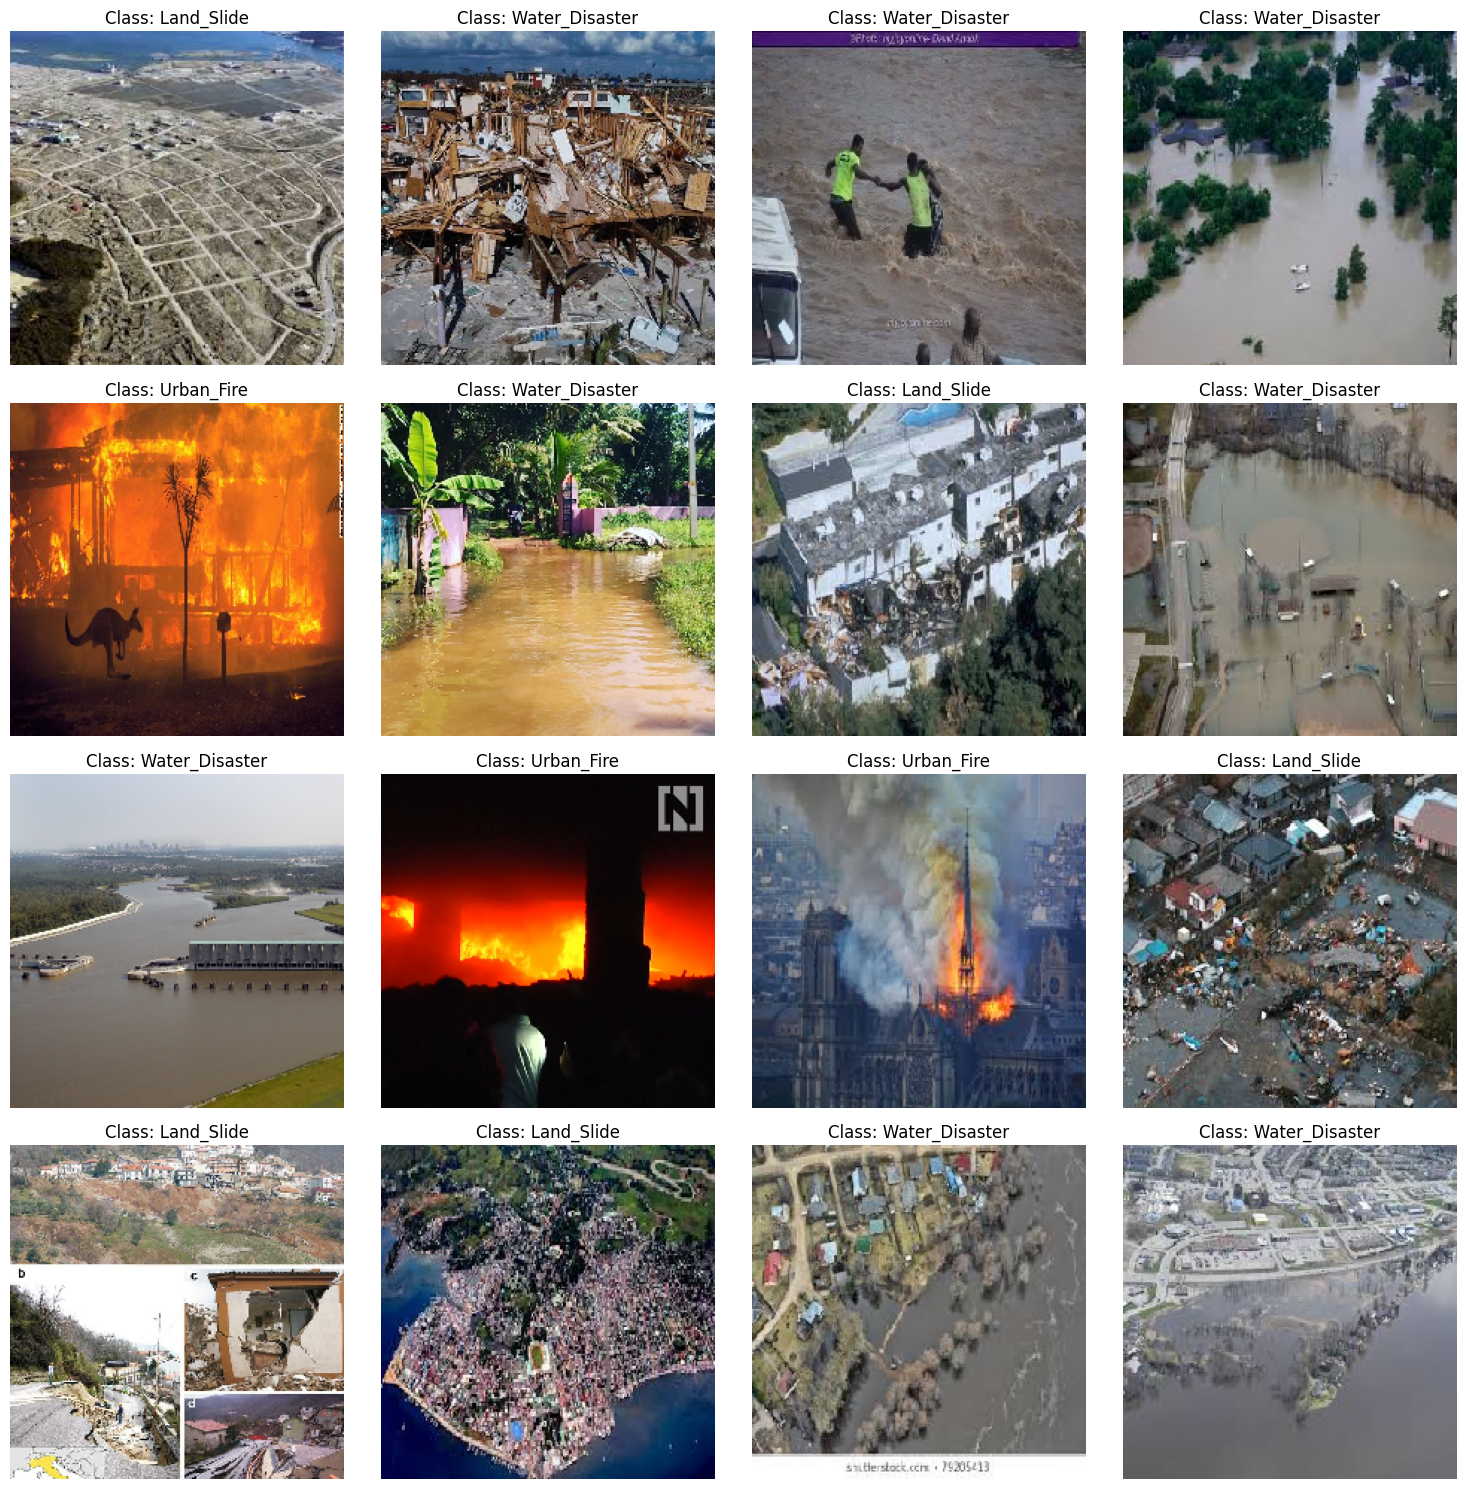

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

sample_images = df.sample(16, random_state=42)
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = row['filepaths']  # Use the full path directly from the dataframe
    
    try:
        # Load and process the image
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        
        # Display the image
        ax = axes[i // 4, i % 4]
        ax.imshow(img_array)
        ax.set_title(f"Class: {row['labels']}")
        ax.axis('off')
    except Exception as e:
        # Handle any errors (file not found, corrupt image, etc.)
        ax = axes[i // 4, i % 4]
        ax.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                ha='center', va='center', wrap=True)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

In [32]:
batch_size = 16
img_size = (260, 260)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [33]:
train_gen = tr_gen.flow_from_dataframe(
    balanced_train_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

train_gen_visual = tr_gen.flow_from_dataframe(
    balanced_train_df, 
    x_col='filepaths', 
    y_col='labels',
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size,
    seed=seed_value
)

Found 3296 validated image filenames belonging to 4 classes.
Found 195 validated image filenames belonging to 4 classes.
Found 195 validated image filenames belonging to 4 classes.
Found 3296 validated image filenames belonging to 4 classes.


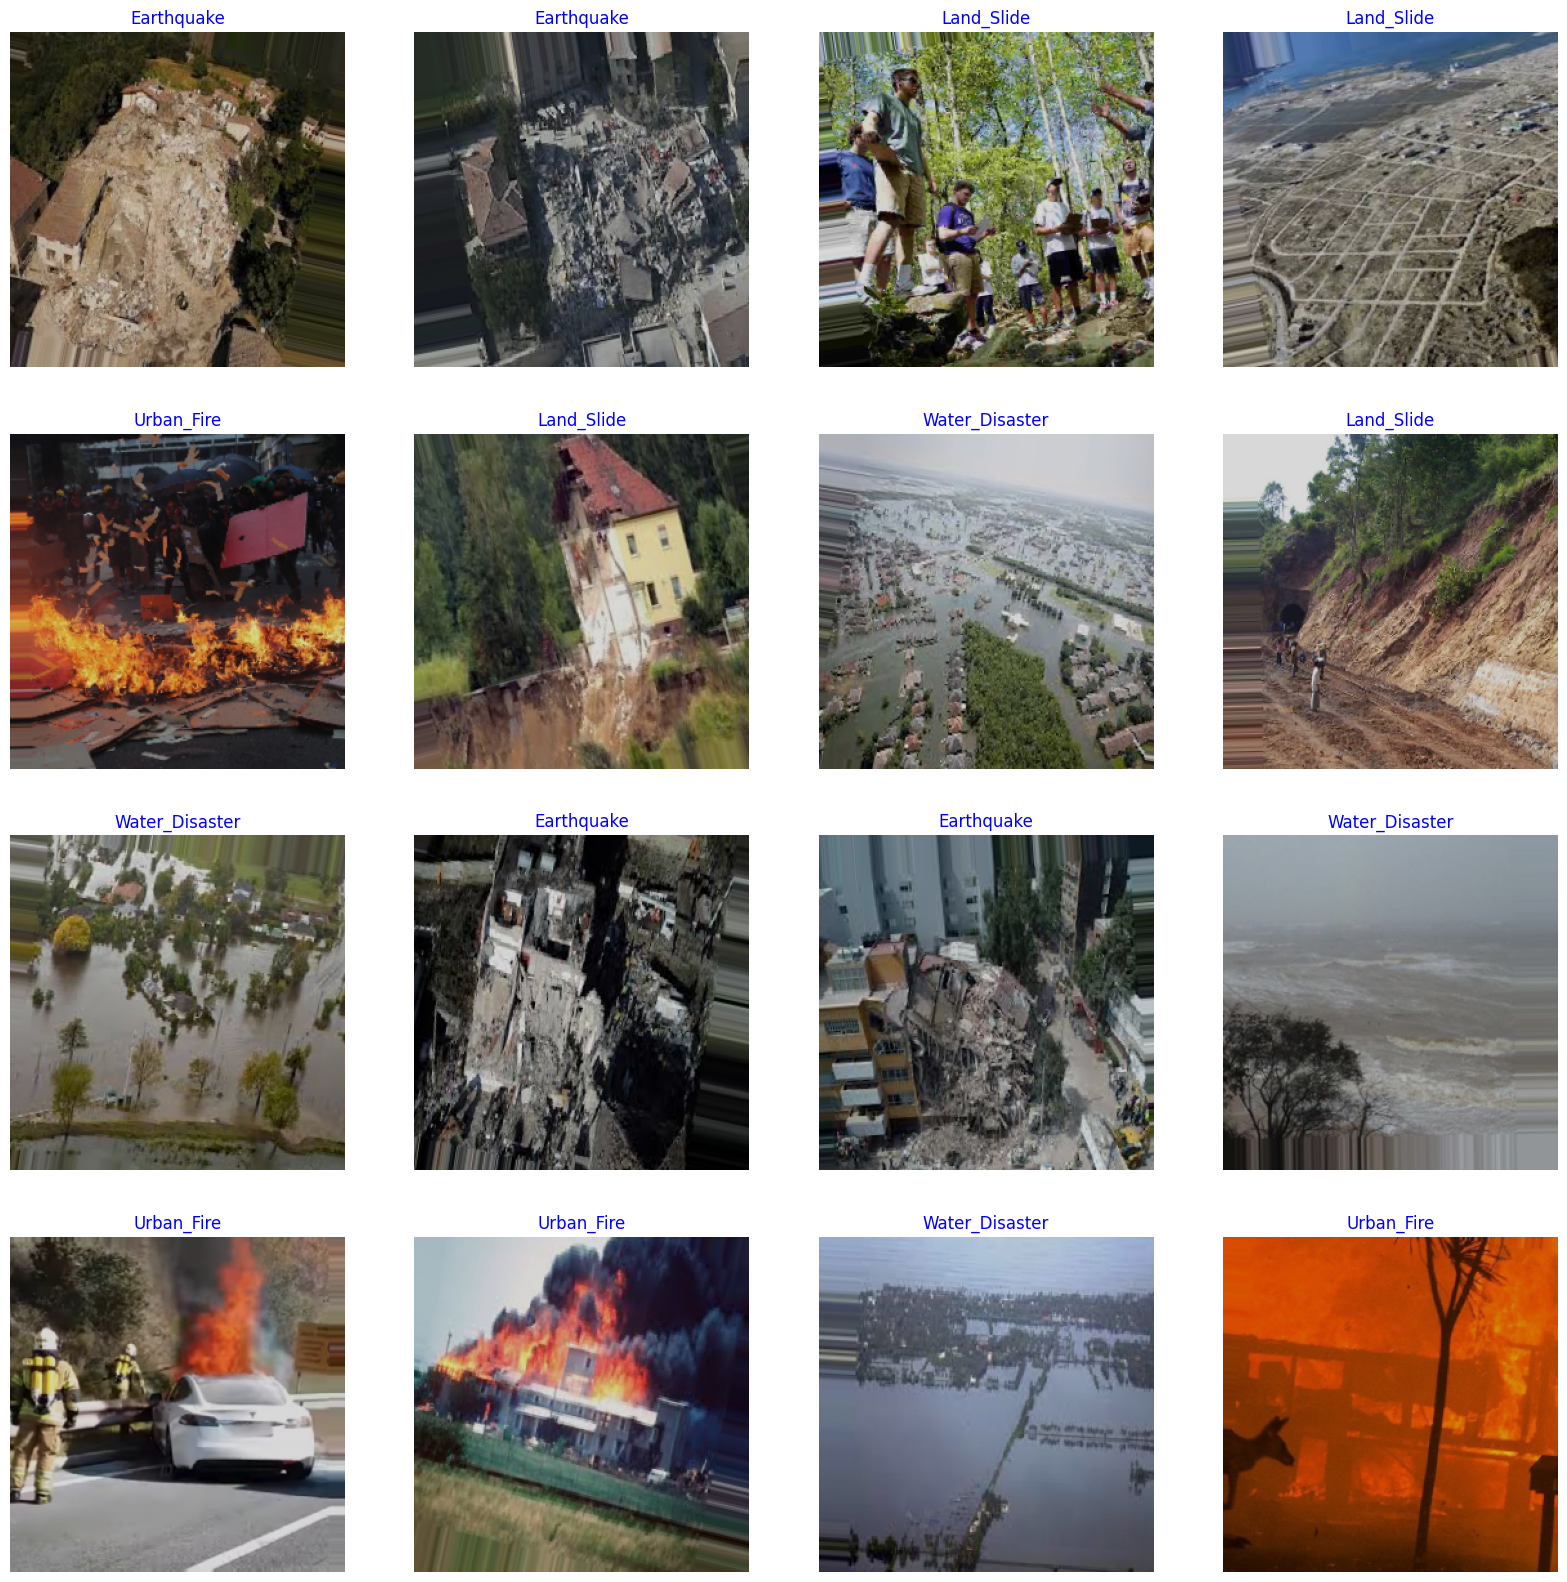

In [34]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 300.0
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model

In [38]:
class_count = len(list(train_gen.class_indices.keys()))

# 1) Model‐embedded preprocessing
inputs = tf.keras.Input(shape=img_shape)

# 2) Backbone
base_model = EfficientNetB2(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model(inputs, training=False)

# 3) Your head
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256,
          kernel_regularizer=regularizers.l2(0.01),
          activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(class_count, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb2 (Functional)          │ (None, 9, 9, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1408)                │           5,632 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         360,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,135,933 (31.04 MB)

 Trainable params: 364,548 (1.39 MB)

 Non-trainable params: 7,771,385 (29.65 MB)

In [39]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    epsilon=0.001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

path_before = '/kaggle/working/effnet_before.keras'

checkpoint1 = ModelCheckpoint(
    filepath=path_before,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)

In [40]:
epochs = 30
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[lr_scheduler, checkpoint1, early_stopping],
    verbose=1
)

print("Loading the best model saved by ModelCheckpoint...")
loaded_model = load_model(path_before)

Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7005 - loss: 4.7052
Epoch 1: val_accuracy improved from -inf to 0.85641, saving model to /kaggle/working/effnet_before.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 105s 333ms/step - accuracy: 0.7009 - loss: 4.7015 - val_accuracy: 0.8564 - val_loss: 2.7065 - learning_rate: 0.0010
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8363 - loss: 2.3481
Epoch 2: val_accuracy improved from 0.85641 to 0.87179, saving model to /kaggle/working/effnet_before.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.8364 - loss: 2.3467 - val_accuracy: 0.8718 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8570 - loss: 1.3754
Epoch 3: val_accuracy improved from 0.87179 to 0.89231, saving model to /kaggle/working/effnet_before.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.8570 - loss: 1.3749 - val_accuracy: 0.8923 - val_loss: 1.0369 - lear

## Model Evaluation

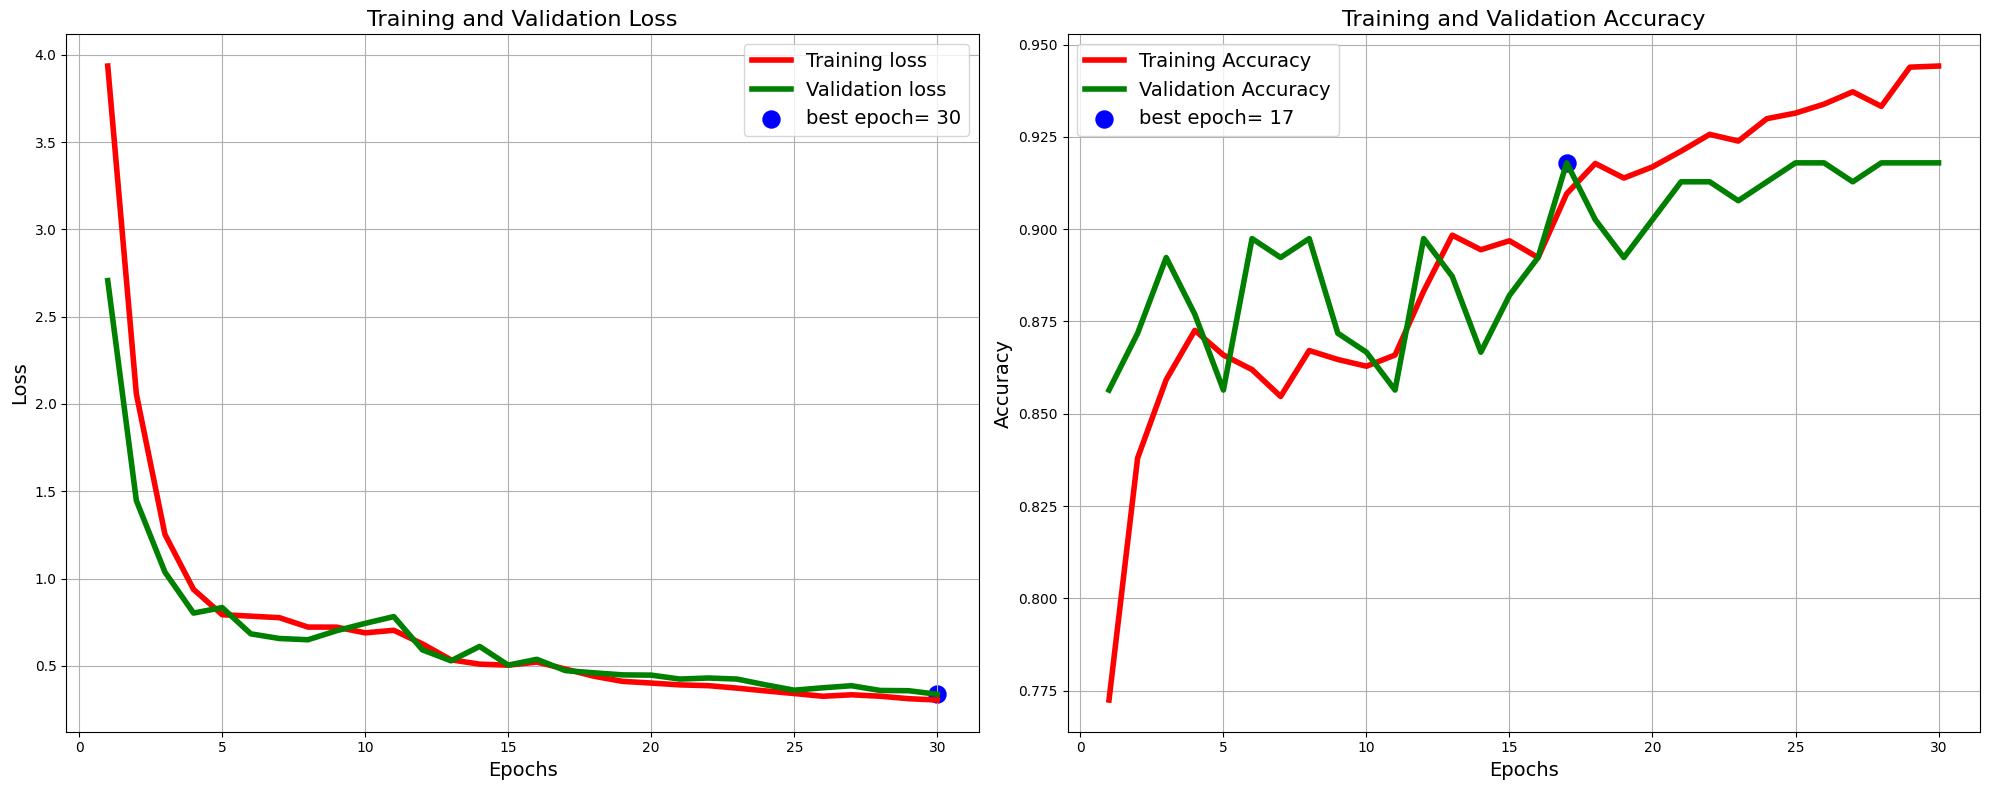

In [41]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.style.use('default')
fig = plt.figure(figsize=(20, 8), facecolor='white')

# Loss plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('white')
ax1.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=4)
ax1.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=4)
ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True)

# Accuracy plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor('white')
ax2.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
ax2.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()


206/206 ━━━━━━━━━━━━━━━━━━━━ 59s 245ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 64s 249ms/step - accuracy: 0.9286 - loss: 0.4143

Training Performance Metrics:
      Metric     Value
0   Accuracy  0.939624
1  Precision  0.941363
2     Recall  0.939624
3   F1 Score  0.938700
4       Loss  0.390758

Training Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.89      1.00      0.94       824
    Land_Slide       0.94      0.83      0.88       824
    Urban_Fire       0.98      0.98      0.98       824
Water_Disaster       0.96      0.96      0.96       824

      accuracy                           0.94      3296
     macro avg       0.94      0.94      0.94      3296
  weighted avg       0.94      0.94      0.94      3296



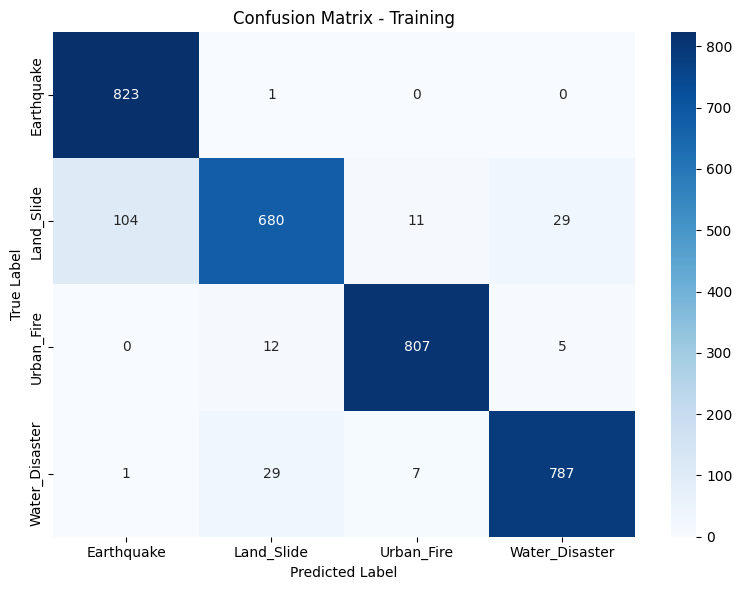

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 822ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 377ms/step - accuracy: 0.8899 - loss: 0.4781

Validation Performance Metrics:
      Metric     Value
0   Accuracy  0.887179
1  Precision  0.915510
2     Recall  0.887179
3   F1 Score  0.897337
4       Loss  0.504744

Validation Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.20      1.00      0.33         2
    Land_Slide       0.88      0.76      0.81        46
    Urban_Fire       0.94      0.86      0.90        35
Water_Disaster       0.94      0.95      0.94       112

      accuracy                           0.89       195
     macro avg       0.74      0.89      0.75       195
  weighted avg       0.92      0.89      0.90       195



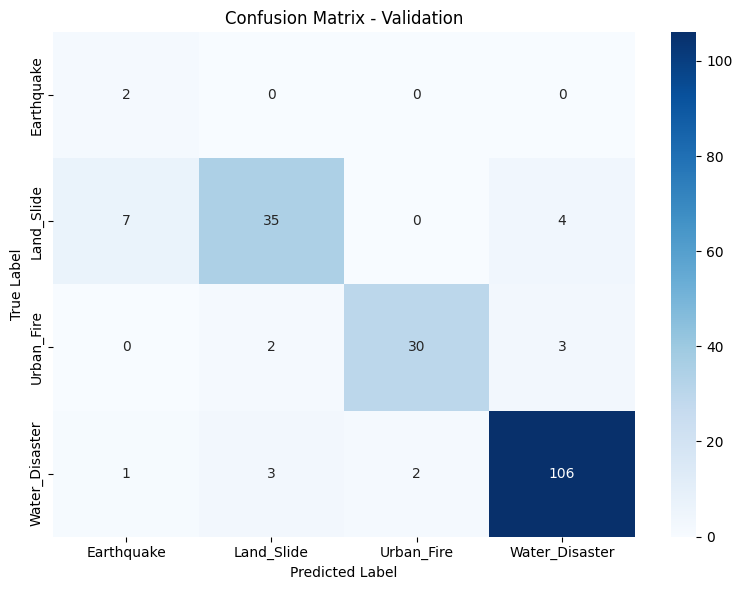

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9200 - loss: 0.4090

Test Performance Metrics:
      Metric     Value
0   Accuracy  0.923077
1  Precision  0.940422
2     Recall  0.923077
3   F1 Score  0.929039
4       Loss  0.432412

Test Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.38      1.00      0.55         3
    Land_Slide       0.82      0.86      0.84        42
    Urban_Fire       1.00      0.96      0.98        51
Water_Disaster       0.98      0.93      0.95        99

      accuracy                           0.92       195
     macro avg       0.79      0.94      0.83       195
  weighted avg       0.94      0.92      0.93       195



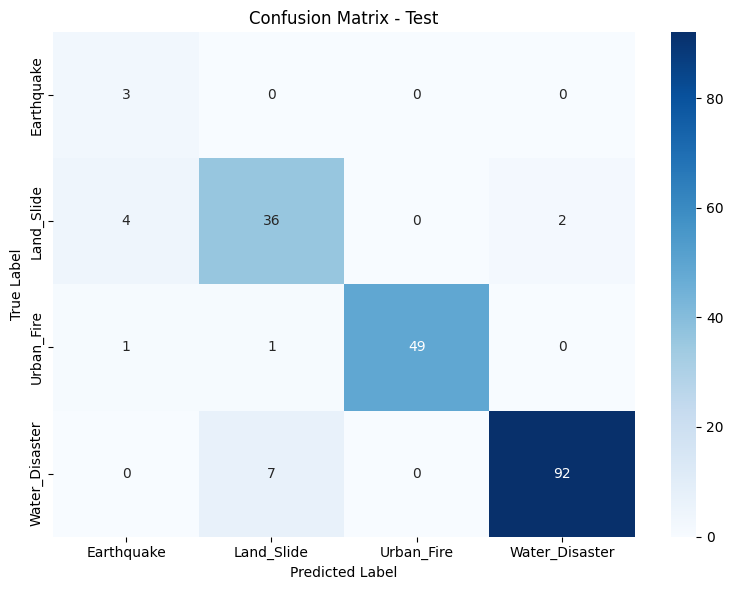


Metrics Comparison Across Sets:
      Metric  Training  Validation      Test
0   Accuracy  0.939624    0.887179  0.923077
1  Precision  0.941363    0.915510  0.940422
2     Recall  0.939624    0.887179  0.923077
3   F1 Score  0.938700    0.897337  0.929039
4       Loss  0.390758    0.504744  0.432412


In [42]:
def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)

    # Generate and display classification report
    print(f"\n{set_name} Classification Report:")
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=False)
    print(report)
    
    # Create classification report as DataFrame for later use
    report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics_df, report_df

def evaluate_model_all_sets(model, train_gen, val_gen, test_gen, class_names):
    # Evaluate on all datasets
    train_metrics, train_report = evaluate_model(model, train_gen, "Training", class_names)
    val_metrics, val_report = evaluate_model(model, val_gen, "Validation", class_names)
    test_metrics, test_report = evaluate_model(model, test_gen, "Test", class_names)
    
    # Combine all metrics into a comparison table
    all_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': train_metrics['Metric'],
        'Training': train_metrics['Value'],
        'Validation': val_metrics['Value'],
        'Test': test_metrics['Value']
    })
    
    print("\nMetrics Comparison Across Sets:")
    print(comparison_df)
    
    return all_metrics

# Example usage:
class_names = list(test_gen.class_indices.keys())
all_metrics = evaluate_model_all_sets(loaded_model, train_gen_visual, valid_gen, test_gen, class_names)

# Model Fine Tuning

In [43]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    epsilon=0.001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

path_tune = '/kaggle/working/effnet_tune.keras'

checkpoint2 = ModelCheckpoint(
    filepath=path_tune,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)

In [45]:
fine_tune_epochs = 15
history_fine = loaded_model.fit(
    train_gen,
    epochs=fine_tune_epochs,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    callbacks=[lr_scheduler, checkpoint2, early_stopping],
    verbose=1
)

print("Loading the best model saved by ModelCheckpoint...")
loaded_tune_model = load_model(path_tune)

Epoch 1/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9079 - loss: 0.4661
Epoch 1: val_accuracy improved from -inf to 0.90769, saving model to /kaggle/working/effnet_tune.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 256ms/step - accuracy: 0.9079 - loss: 0.4660 - val_accuracy: 0.9077 - val_loss: 0.4373 - learning_rate: 2.5000e-04
Epoch 2/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9115 - loss: 0.4184
Epoch 2: val_accuracy did not improve from 0.90769
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/step - accuracy: 0.9116 - loss: 0.4183 - val_accuracy: 0.9077 - val_loss: 0.4249 - learning_rate: 2.5000e-04
Epoch 3/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9251 - loss: 0.3896
Epoch 3: val_accuracy did not improve from 0.90769
206/206 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.9251 - loss: 0.3896 - val_accuracy: 0.8923 - val_loss: 0.4363 - learning_rate: 2.5000e-04
Epoch 4/15
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9218 - loss: 0.3938

## Model Tune Evaluation

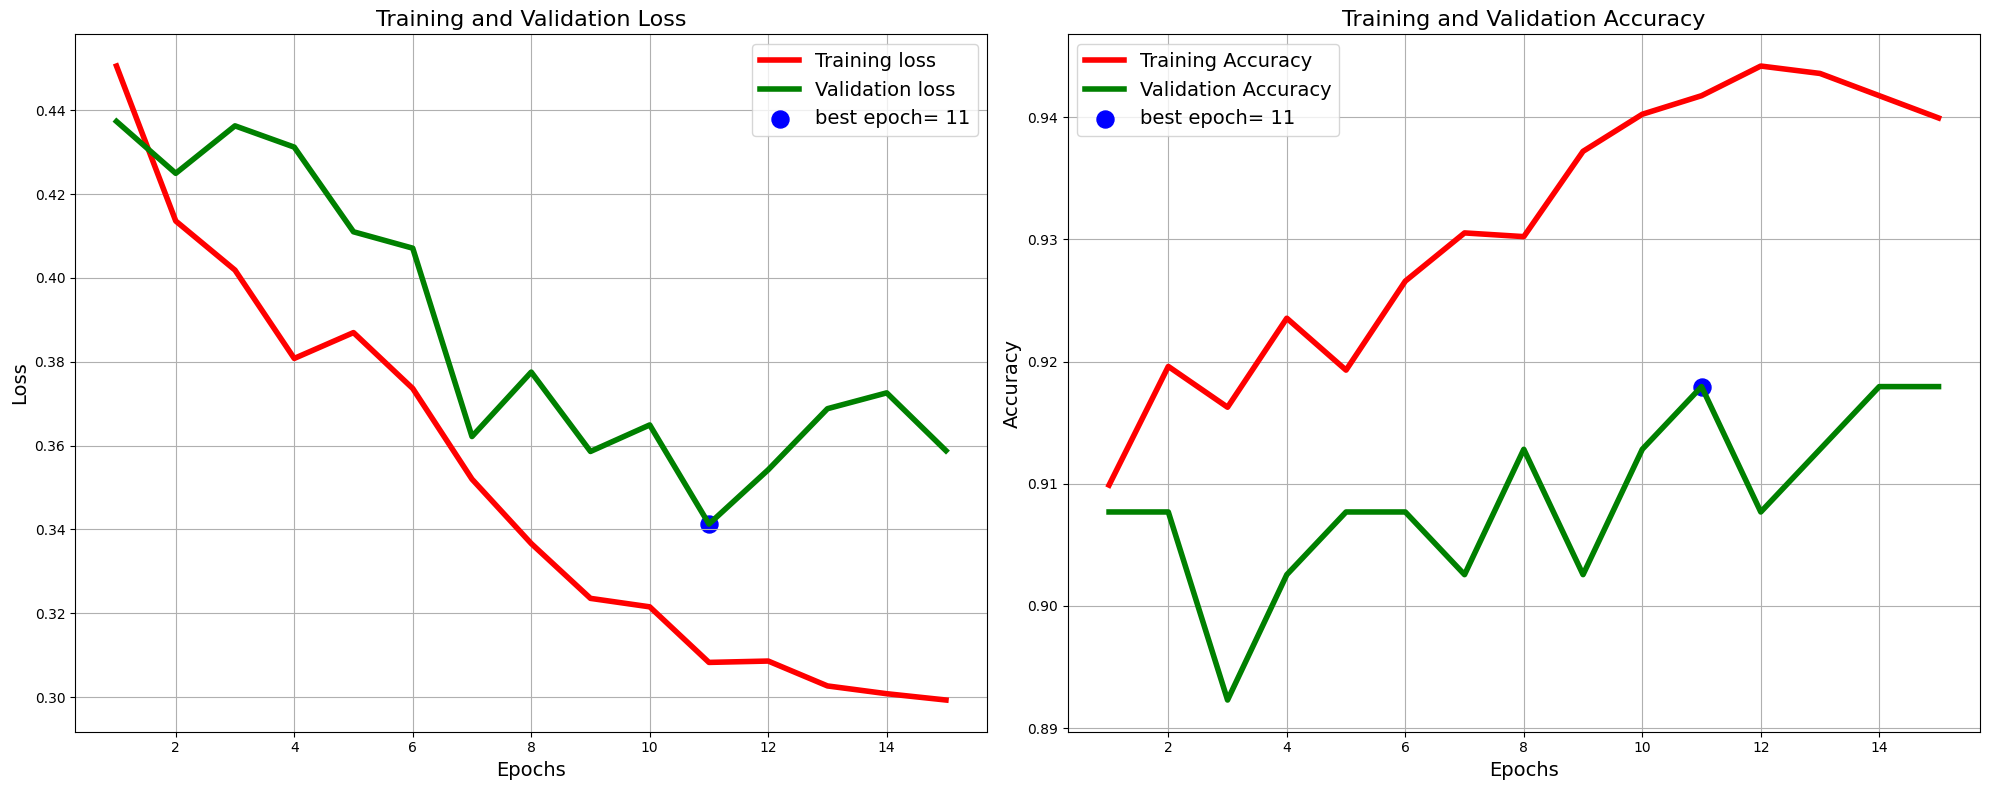

In [47]:
# Define needed variables
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.style.use('default')
fig = plt.figure(figsize=(20, 8), facecolor='white')

# Loss plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_facecolor('white')
ax1.plot(Epochs, tr_loss, 'r', label='Training loss', linewidth=4)
ax1.plot(Epochs, val_loss, 'g', label='Validation loss', linewidth=4)
ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend(fontsize=14)
ax1.grid(True)

# Accuracy plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor('white')
ax2.plot(Epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
ax2.plot(Epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()

206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 246ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - accuracy: 0.9595 - loss: 0.2428

Training Performance Metrics:
      Metric     Value
0   Accuracy  0.969964
1  Precision  0.970749
2     Recall  0.969964
3   F1 Score  0.969796
4       Loss  0.232466

Training Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.93      1.00      0.96       824
    Land_Slide       0.97      0.91      0.94       824
    Urban_Fire       1.00      0.99      1.00       824
Water_Disaster       0.98      0.98      0.98       824

      accuracy                           0.97      3296
     macro avg       0.97      0.97      0.97      3296
  weighted avg       0.97      0.97      0.97      3296



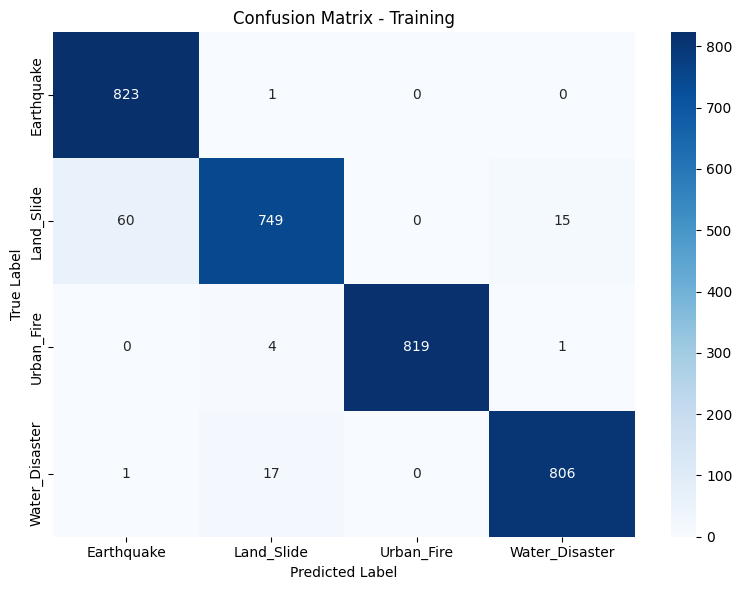

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 846ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.9177 - loss: 0.3417

Validation Performance Metrics:
      Metric     Value
0   Accuracy  0.917949
1  Precision  0.943208
2     Recall  0.917949
3   F1 Score  0.926630
4       Loss  0.341276

Validation Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.22      1.00      0.36         2
    Land_Slide       0.92      0.78      0.85        46
    Urban_Fire       0.94      0.97      0.96        35
Water_Disaster       0.96      0.96      0.96       112

      accuracy                           0.92       195
     macro avg       0.76      0.93      0.78       195
  weighted avg       0.94      0.92      0.93       195



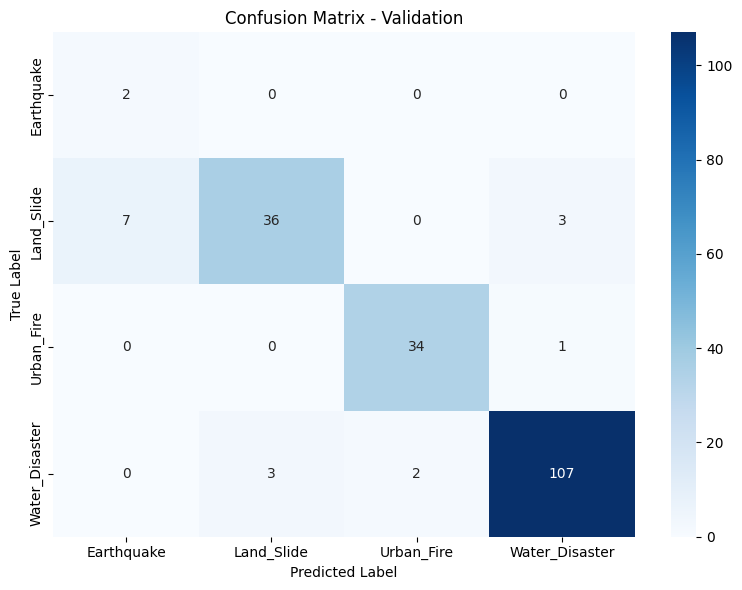

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9644 - loss: 0.2743

Test Performance Metrics:
      Metric     Value
0   Accuracy  0.953846
1  Precision  0.959784
2     Recall  0.953846
3   F1 Score  0.955581
4       Loss  0.291104

Test Classification Report:
                precision    recall  f1-score   support

    Earthquake       0.60      1.00      0.75         3
    Land_Slide       0.87      0.93      0.90        42
    Urban_Fire       1.00      0.98      0.99        51
Water_Disaster       0.99      0.95      0.97        99

      accuracy                           0.95       195
     macro avg       0.86      0.96      0.90       195
  weighted avg       0.96      0.95      0.96       195



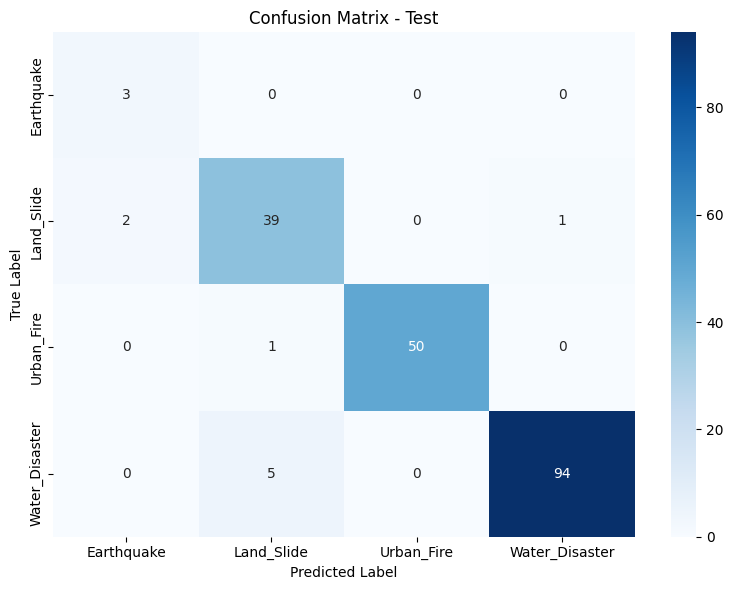


Metrics Comparison Across Sets:
      Metric  Training  Validation      Test
0   Accuracy  0.969964    0.917949  0.953846
1  Precision  0.970749    0.943208  0.959784
2     Recall  0.969964    0.917949  0.953846
3   F1 Score  0.969796    0.926630  0.955581
4       Loss  0.232466    0.341276  0.291104


In [48]:
def evaluate_model(model, data_generator, set_name, class_names):
    # Reset generator and get batch size
    data_generator.reset()
    batch_size = data_generator.batch_size
    
    # Get predictions
    y_pred = model.predict(data_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = data_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    # Calculate loss
    loss = model.evaluate(data_generator, verbose=1)[0]
    
    # Create metrics dataframe
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss'],
        'Value': [accuracy, precision, recall, f1, loss]
    })
    
    # Display metrics table
    print(f"\n{set_name} Performance Metrics:")
    print(metrics_df)

    # Generate and display classification report
    print(f"\n{set_name} Classification Report:")
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=False)
    print(report)
    
    # Create classification report as DataFrame for later use
    report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics_df, report_df

def evaluate_model_all_sets(model, train_gen, val_gen, test_gen, class_names):
    # Evaluate on all datasets
    train_metrics, train_report = evaluate_model(model, train_gen, "Training", class_names)
    val_metrics, val_report = evaluate_model(model, val_gen, "Validation", class_names)
    test_metrics, test_report = evaluate_model(model, test_gen, "Test", class_names)
    
    # Combine all metrics into a comparison table
    all_metrics = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': train_metrics['Metric'],
        'Training': train_metrics['Value'],
        'Validation': val_metrics['Value'],
        'Test': test_metrics['Value']
    })
    
    print("\nMetrics Comparison Across Sets:")
    print(comparison_df)
    
    return all_metrics

# Example usage:
class_names = list(test_gen.class_indices.keys())
all_metrics = evaluate_model_all_sets(loaded_tune_model, train_gen_visual, valid_gen, test_gen, class_names)